# Tutorial 1: Optimisation Basics

**Objectives:**
- Understand the ScalarBuilder API
- Optimise the classic Rosenbrock function
- Visualise optimisation landscapes with contour plots
- Compare different optimisers

## Introduction

The Rosenbrock function is a classic test problem in optimization. It's defined as:

$$f(x, y) = (1 - x)^2 + 100(y - x^2)^2$$

The global minimum is at $(1, 1)$ with $f(1, 1) = 0$. Despite being simple to state, it's challenging for optimisers because of its narrow, curved valley.

In [1]:
# Import plotting utilities
import chronopt as chron
import matplotlib.pyplot as plt
import numpy as np
from chronopt.plotting import contour_2d

## Define the Objective Function

In Chronopt, objective functions must:
1. Accept a NumPy array as input
2. Return a NumPy array as output (even for scalar values)

In [2]:
def rosenbrock(x):
    """The Rosenbrock function."""
    value = (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2
    return np.array([value], dtype=float)

## Build the Problem

Use `ScalarBuilder` for direct function optimization:

In [3]:
builder = (
    chron.ScalarBuilder()
    .with_callable(rosenbrock)
    .with_parameter("x", 10.0)  # Initial guess
    .with_parameter("y", 10.0)  # Initial guess
)
problem = builder.build()

print("Problem built successfully!")
print("Number of parameters: 2")

Problem built successfully!
Number of parameters: 2


## Optimise with Default Settings

The problem class is constructed as the core object in chronopt, as such
 an `optimise()` method if provided for fast optimisation. This uses Nelder-Mead by default:

In [4]:
result = problem.optimise()  # Uses initial guesses provided

print("\n" + "=" * 50)
print("OPTIMIZATION RESULTS")
print("=" * 50)
print(f"Success: {result.success}")
print(f"Optimal parameters: {result.x}")
print(f"Objective value: {result.value:.3e}")
print(f"Iterations: {result.iterations}")
print(f"Function evaluations: {result.evaluations}")
print(f"Message: {result.message}")


OPTIMIZATION RESULTS
Success: True
Optimal parameters: [1.00082688 1.0017059 ]
Objective value: 9.484e-07
Iterations: 159
Function evaluations: 342
Message: Function tolerance met


## Visualise the Optimization Landscape

Let's create a contour plot to see the function's shape:

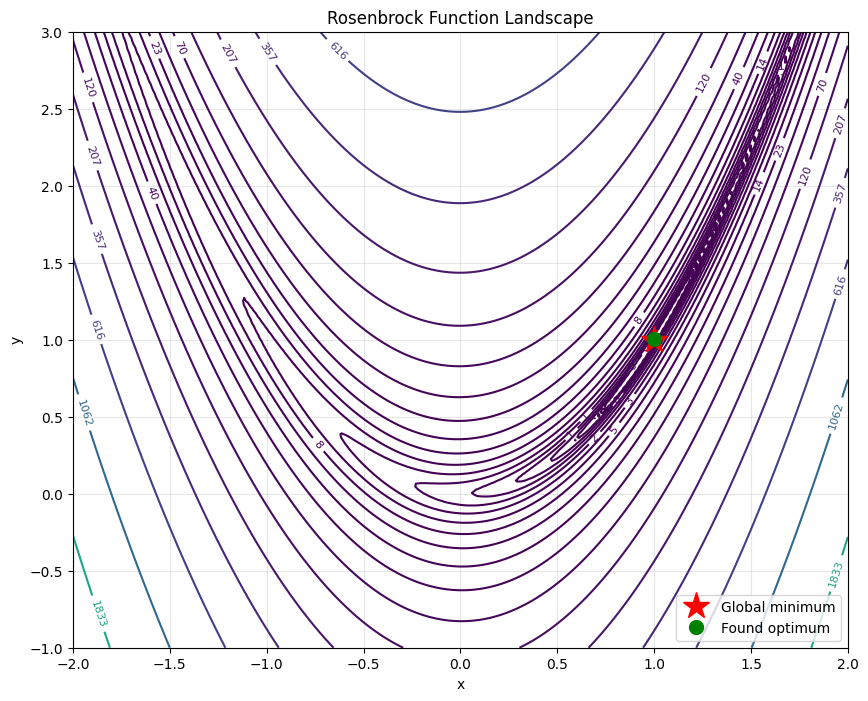

Distance from true optimum: 1.896e-03


In [5]:
# Create contour plot
fig, ax = contour_2d(
    rosenbrock,
    xlim=(-2, 2),
    ylim=(-1, 3),
    levels=np.logspace(-1, 3.5, 20),
    optimum=(1.0, 1.0),
    found=(result.x[0], result.x[1]),
    title="Rosenbrock Function Landscape",
    show=False,
)

plt.show()

print(f"Distance from true optimum: {np.linalg.norm(result.x - [1.0, 1.0]):.3e}")

## Compare Different Optimisers

Let's compare Nelder-Mead, CMA-ES, and Adam:

In [58]:
# Define optimisers
optimisers = {
    "Nelder-Mead": chron.NelderMead().with_max_iter(1000),
    "CMA-ES": chron.CMAES().with_max_iter(300).with_step_size(0.5),
    "Adam": chron.Adam().with_max_iter(2000).with_step_size(0.25).with_threshold(1e-12),
}

# Test starting point
initial_guess = [-1.0, -3.0]

# Run all optimisers
results = {}
for name, optimiser in optimisers.items():
    result = optimiser.run(problem, initial_guess)
    results[name] = result

# Display comparison
print("\n" + "=" * 70)
print("OPTIMISER COMPARISON")
print("=" * 70)
print(
    f"{'Optimiser':<15} {'Success':<10} {'Final Value':<15} {'Iterations':<12} {'Evaluations'}"
)
print("-" * 70)

for name, result in results.items():
    print(
        f"{name:<15} {str(result.success):<10} {result.value:<15.3e} "
        f"{result.iterations:<12} {result.evaluations}"
    )

print("\nFinal parameters:")
for name, result in results.items():
    print(f"{name:<15} x = {result.x}")


OPTIMIZER COMPARISON
Optimizer       Success    Final Value     Iterations   Evaluations
----------------------------------------------------------------------
Nelder-Mead     True       2.866e-07       130          290
CMA-ES          True       1.304e-09       78           469
Adam            False      6.927e-09       2000         2001

Final parameters:
Nelder-Mead     x = [1.0001253  1.00019857]
CMA-ES          x = [0.99997614 0.999955  ]
Adam            x = [1.00008317 1.00016666]


## Visualise All Results

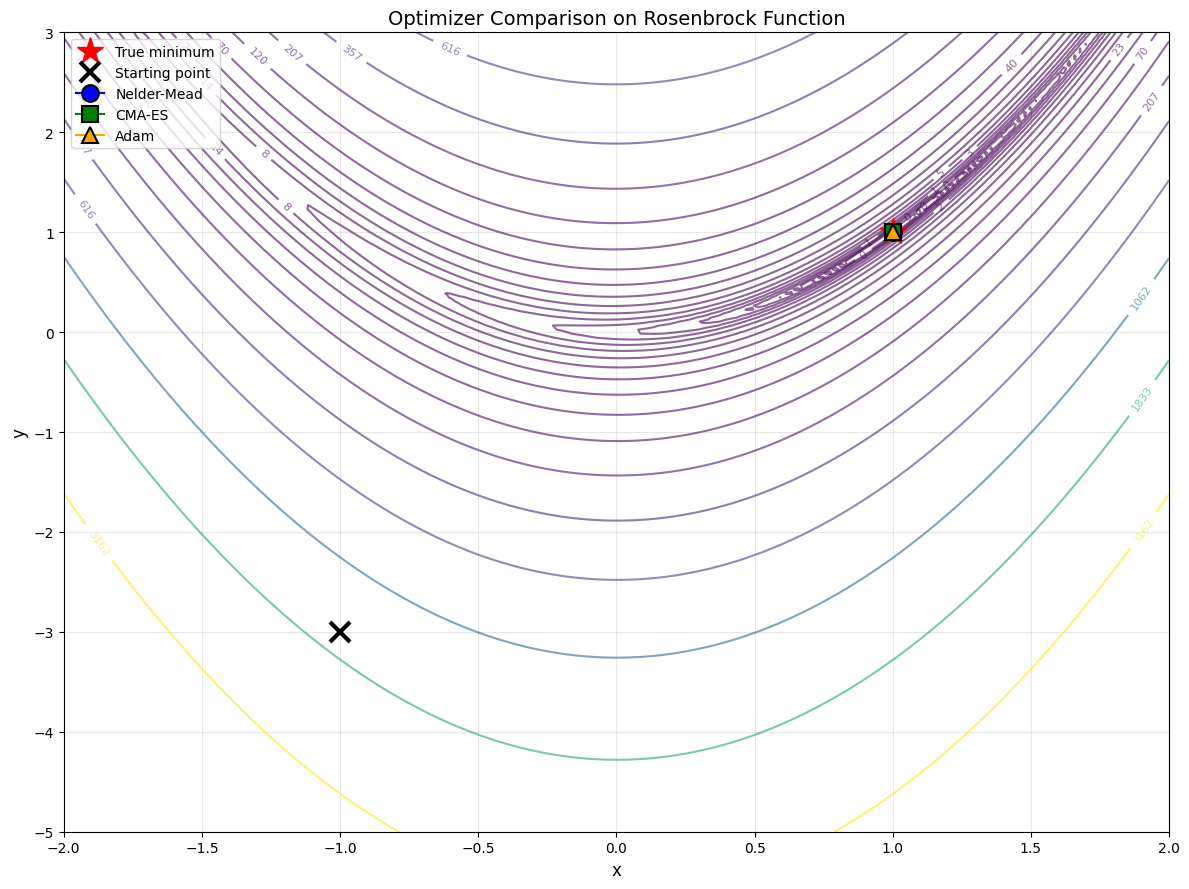

In [59]:
# Create contour plot with all optimisers' results
x = np.linspace(-2, 2, 200)
y = np.linspace(-5, 3, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = rosenbrock([X[i, j], Y[i, j]])[0]

fig, ax = plt.subplots(figsize=(12, 9))

# Plot contours
levels = np.logspace(-1, 3.5, 20)
cs = ax.contour(X, Y, Z, levels=levels, cmap="viridis", alpha=0.6)
ax.clabel(cs, inline=True, fontsize=8)

# Plot true optimum
ax.plot(1.0, 1.0, "r*", markersize=20, label="True minimum", zorder=5)

# Plot starting point
ax.plot(
    initial_guess[0],
    initial_guess[1],
    "kx",
    markersize=15,
    markeredgewidth=3,
    label="Starting point",
    zorder=5,
)

# Plot optimiser results
colors = {"Nelder-Mead": "blue", "CMA-ES": "green", "Adam": "orange"}
markers = {"Nelder-Mead": "o", "CMA-ES": "s", "Adam": "^"}

for name, result in results.items():
    ax.plot(
        result.x[0],
        result.x[1],
        marker=markers[name],
        color=colors[name],
        markersize=12,
        label=name,
        zorder=5,
        markeredgecolor="black",
        markeredgewidth=1.5,
    )

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Optimiser Comparison on Rosenbrock Function", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()

## Effect of Starting Point

Let's see how starting position affects convergence:

In [60]:
# Try multiple starting points
starting_points = [
    [-1.5, -0.5],
    [1.5, 1.5],
    [0.0, 2.0],
    [-1.0, 1.0],
]

optimiser = chron.NelderMead().with_max_iter(1000)

print("\n" + "=" * 60)
print("STARTING POINT SENSITIVITY")
print("=" * 60)

for i, start in enumerate(starting_points, 1):
    result = optimiser.run(problem, start)
    error = np.linalg.norm(result.x - [1.0, 1.0])

    print(f"\nStart {i}: {start}")
    print(f"  Final:      {result.x}")
    print(f"  Iterations: {result.iterations}")
    print(f"  Error:      {error:.3e}")
    print(f"  Success:    {result.success}")


STARTING POINT SENSITIVITY

Start 1: [-1.5, -0.5]
  Final:      [0.99938601 0.99871559]
  Iterations: 60
  Error:      1.424e-03
  Success:    True

Start 2: [1.5, 1.5]
  Final:      [1.00023483 1.00043031]
  Iterations: 79
  Error:      4.902e-04
  Success:    True

Start 3: [0.0, 2.0]
  Final:      [1.00004402 1.00004508]
  Iterations: 65
  Error:      6.301e-05
  Success:    True

Start 4: [-1.0, 1.0]
  Final:      [1.00040626 1.0008615 ]
  Iterations: 105
  Error:      9.525e-04
  Success:    True


## Key Takeaways

1. **ScalarBuilder** is used for direct function optimisation
2. **Nelder-Mead** is provided as the default optimiser - good for small problems
3. **CMA-ES** is more robust for global search but requires more evaluations
4. **Adam** can be fast on smooth problems but may struggle on complex landscapes
5. Starting point can significantly affect convergence speed

## Next Steps

- [Tutorial 2: ODE Fitting with DiffSL](02_ode_fitting_diffsol.ipynb) - Learn how to fit differential equations
- [Choosing an Optimiser](../../guides/choosing-optimiser.md) - Detailed optimiser selection guide
- [API Reference: Optimisers](../../api-reference/python/optimisers.md) - Complete API documentation

## Exercises

Try these challenges:

1. **Rastrigin Function**: Implement and optimise:
   $$f(x, y) = 20 + x^2 + y^2 - 10(\cos(2\pi x) + \cos(2\pi y))$$
   
2. **Parameter Tuning**: Experiment with CMA-ES `step_size` parameter (try 0.1, 0.5, 1.0, 2.0)

3. **Constraint Handling**: How would you restrict the search to $x, y \in [-2, 2]$?